In [1]:
import numpy as np
import os
from pathlib import Path
from keras.preprocessing import image
from matplotlib import pyplot as plt

In [2]:
p = Path("dataset")
dirs = p.glob("*")
image_data = []
labels = []
labels_dir = {"cat":0 ,"dog":1 ,"horse":2 ,"human":3}
for folder_name in dirs:
    label = str(folder_name).split("\\")[-1][:-1]
    

    for img_path in folder_name.glob('*.jpg'):
        img = image.load_img(img_path, target_size=(32,32))
        img_arr = image.img_to_array(img)
        image_data.append(img_arr)
        labels.append(labels_dir[label])

In [3]:
print(len(image_data))
print(len(labels))

1200
1200


In [4]:
image_data = np.array(image_data, dtype='float32')/255.0
labels = np.array(labels)

In [5]:
print(image_data.shape,labels.shape)


(1200, 32, 32, 3) (1200,)


In [6]:
import random
combine = list(zip(image_data,labels))
random.shuffle(combine)
image_data[:],labels[:] = zip(*combine)

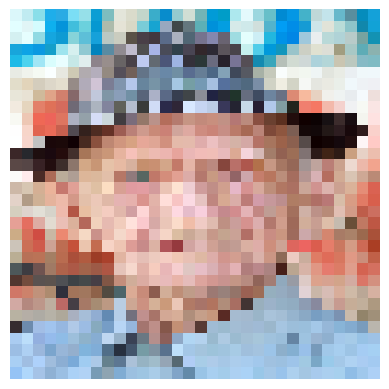

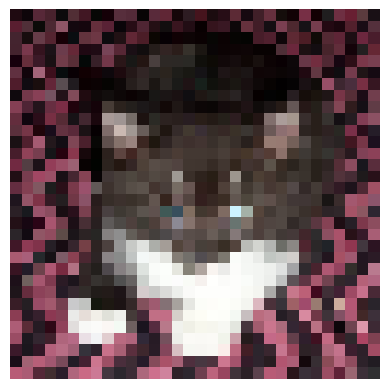

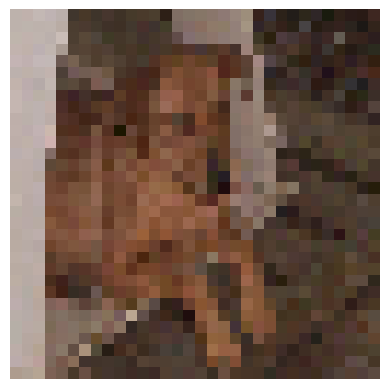

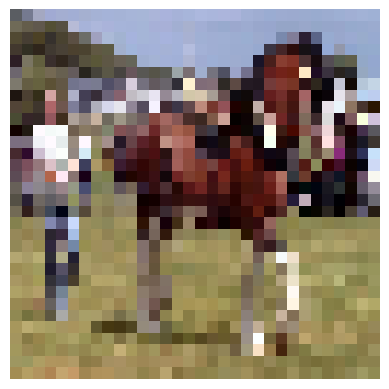

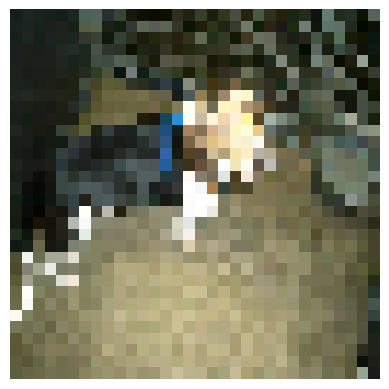

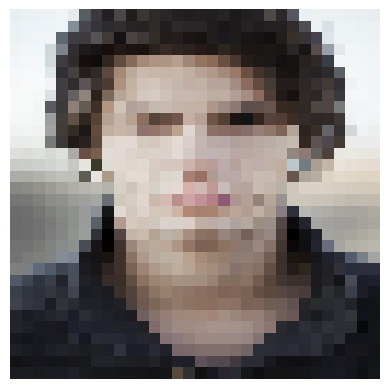

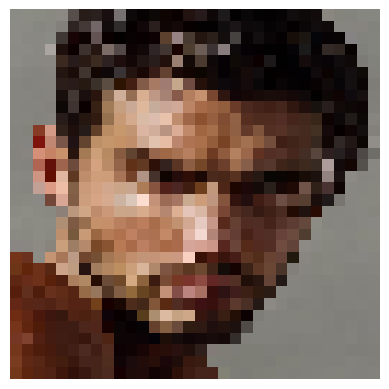

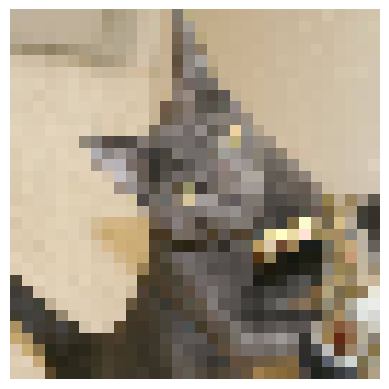

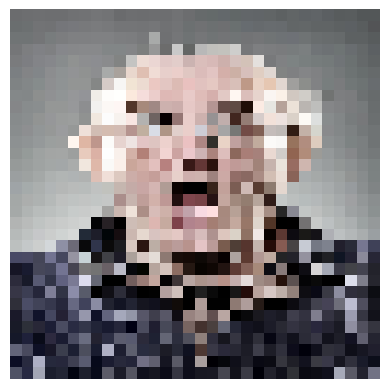

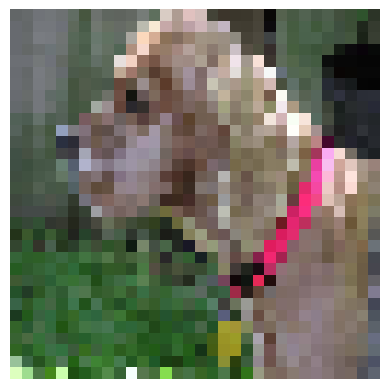

In [7]:
def draw(img):
    plt.imshow(img)
    plt.axis("off")
    plt.show()
    return
for i in range(10):
  draw(image_data[i])

SVM Classifier

In [8]:
import numpy as np

class SVM: 
    def __init__(self, C=1.0):
        self.C = C
        self.W = 0
        self.b = 0

    def hingeloss(self, W, b, X, Y):
        loss = 0.0
        loss += 0.5 * np.dot(W, W.T)  
        m = X.shape[0]
        for i in range(m): 
            ti = Y[i] * (np.dot(W, X[i].T) + b)
            loss += self.C * max(0, (1 - ti))
        return loss[0][0]  

    def fit(self, X, Y, batch_size=100, learning_rate=0.00001, maxitr=1000):
        no_of_features = X.shape[1]
        no_of_samples = X.shape[0]
        n = learning_rate
        c = self.C
        W = np.zeros((1, no_of_features))
        bias = 0
        losses = []

        for itr in range(maxitr):
            l = self.hingeloss(W, bias, X, Y)
            losses.append(l)
            ids = np.arange(no_of_samples)
            np.random.shuffle(ids)

            for batch_start in range(0, no_of_samples, batch_size):
                gradw = 0
                gradb = 0

                for j in range(batch_start, batch_start + batch_size):
                    if j < no_of_samples:
                        i = ids[j]
                        ti = Y[i] * (np.dot(W, X[i].T) + bias)
                        if ti < 1:
                            gradw += c * Y[i] * X[i]
                            gradb += c * Y[i]

                W = W - n * W + n * gradw
                bias = bias + n * gradb

        self.W = W
        self.b = bias
        return W, bias, losses


One VS One

In [9]:
M = image_data.shape[0]
image_data = image_data.reshape(M,-1)
print(image_data.shape)
print(labels.shape)

(1200, 3072)
(1200,)


In [10]:
classes = len(np.unique(labels))
print(classes)

4


In [11]:
def classData(x,y):
    data = {}
    for i in range(classes):
        data[i] = []
    for i in range(x.shape[0]):
        data[y[i]].append(x[i])
    for k in data.keys():
        data[k] = np.array(data[k])
    return data

In [12]:
data = classData(image_data,labels)

In [13]:
def getDataPair(d1,d2):
    l1,l2 = d1.shape[0],d2.shape[0] 
    samples = l1+l2 
    features = d1.shape[1] 
    data_pair = np.zeros((samples, features)) 
    data_labels = np.zeros((samples,)) 
    data_pair[:l1,:] = d1 
    data_pair[l1:,:] = d2 
    data_labels[:l1] = -1 
    data_labels[l1:] = +1 
    return data_pair, data_labels

Training

In [14]:
mysvm = SVM()

In [15]:
def trainSVM(x,y):
    svm_classifiers = {}
    for i in range(classes):
        svm_classifiers[i] = {} 
        for j in range(i+1,classes): 
            xpair,ypair = getDataPair(data[i], data[j]) 
            wts, b, loss = mysvm.fit(xpair, ypair, learning_rate=0.00001, maxitr=1000) 
            svm_classifiers[i][j] = (wts,b) 
    return svm_classifiers

In [16]:
svm_classifiers = trainSVM(image_data,labels)

In [17]:
svm_classifiers[0][1] #cats and dogs

(array([[ 0.01440614,  0.02213519, -0.00129701, ..., -0.05118859,
         -0.04721948, -0.04417156]]),
 np.float64(-0.026489999999999982))

Prediction

In [18]:
def binaryPredict(x,w,b):
    z = np.dot(x,w.T)+b
    if z>=0:
        return 1
    else:
        return -1

In [19]:
def predict(x):
    count = np.zeros((classes,))
    for i in range(classes):
        for j in range(i+1,classes):
            w,b = svm_classifiers[i][j]
            z = binaryPredict(x,w,b)
            if(z==1):
                count[j] +=1
            else:
                count[i] +=1
        final_prediction = np.argmax(count)
        return final_prediction

In [22]:
print(predict(image_data[2]))
print(labels[2])

0
1


In [23]:
def accuracy(x,y):
    count = 0
    for i in range(x.shape[0]):
        prediction = predict(x[i])
        if (prediction==y[i]):
            count +=1
    return count/x.shape[0]

In [24]:
accuracy(image_data,labels)

0.2708333333333333

sklearn SVM

In [26]:
from sklearn import svm


In [28]:
svc = svm.SVC(kernel ='linear', C=1.0)

In [29]:
svc.fit(image_data,labels)
svc.score(image_data,labels)

0.6691666666666667